In [2]:
import numpy as np
import matplotlib.pyplot as plt
import requests

Download dataset (u_xyz_timesteps.npz) into your current working directory: https://drive.google.com/file/d/1Q9myuVADlv5lYKgQ7JIjldH0mAeytfro/view?usp=sharing

The numerical simulation provides the whole 3D information simultaneously at any time-step. We extract 800 time-steps after it gets a sustained oscillation of the velocity.
The original dataset has 4 dimensions (time-steps, X, Y, Z). The numbers of cells is X*Y*Z

In [3]:
filename = './/u_xyz_timesteps.npz'
temp = np.load(filename)
u_series = (temp['a'])[:, :, :, :]
u_series.shape

FileNotFoundError: [Errno 2] No such file or directory: './/dataset//wxyzt_serie.npz'

The central X-plane for step = 0 is:

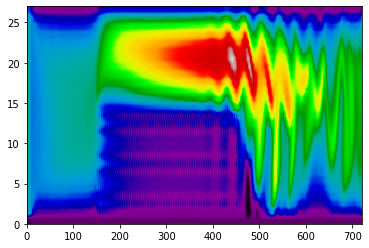

In [3]:
Z = np.flip(u_series[0][int(u_series.shape[1]/2)].copy(), 0)
cp = plt.imshow(Z, aspect='auto', cmap = 'nipy_spectral', extent = [0, Z.shape[1], 0, Z.shape[0]])

We need to preprocess data before it can be used. First we simplifies dataset to a 2D array where the first dimension are cells and the second dimension are time-steps. Thus, a method is implemented to obtain a 2D array from a defined region

In [4]:
def get_converted_region(u_series,minX,maxX,dx,minY,maxY,dy,minZ,maxZ,dz,n_series):
    u = np.zeros(shape=(int((maxX-minX)/dx)*int((maxY-minY)/dy)*int((maxZ-minZ)/dz),n_series), dtype=np.float32)
    i = 0
    for x in range(minX, maxX, dx):
        for z in range(minZ, maxZ, dz):
            for y in range(minY, maxY, dy):
                u[i, 0:n_series] = u_series[0:n_series, x, y, z]
                i = i+1            
    return u 

All results are presented for the volume contained between one of the lateral walls and the central symmetry plane. Then we get 2D dataset

In [5]:
minX = 0
maxX = 10
minY = 0
maxY = 27    
minZ = 350
maxZ = 550
dx = 1
dy = 1
dz = 1
n_series = 800
d0 = int((maxX-minX)/dx)
d1 = int((maxY-minY)/dy)
d2 = int((maxZ-minZ)/dz)
u2d = get_converted_region(u_series,minX,maxX,dx,minY,maxY,dy,minZ,maxZ,dz,n_series)
n_cells = u2d.shape[0]
n_steps = u2d.shape[1]   

The final dataset has in each cell-time the original value minus the mean value

In [7]:
data = np.zeros(shape=(n_cells, n_steps))
data_mean = np.zeros(shape = (n_cells))
data_mean[0:n_cells] = np.mean(u2d[0:n_cells, 0:n_steps], axis = 1)
data[0:n_cells, 0:n_steps] = u2d[0:n_cells, 0:n_steps] - np.tile(np.array([data_mean[0:n_cells]]).transpose(),(1, n_steps))            

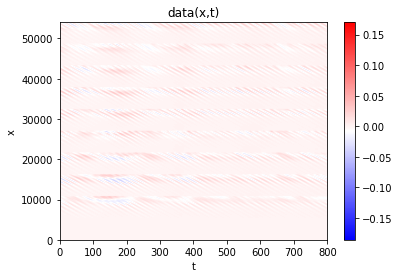

In [8]:
n_figure = 1
plt.figure(n_figure)
Z = np.flip((data.copy()), 0)
cp = plt.imshow(Z[:, :], aspect = 'auto', cmap = 'bwr',extent = [0, n_steps, 0, n_cells])
plt.colorbar(cp)
plt.title('data(x,t)')
plt.xlabel('t')
plt.ylabel('x')  
plt.show()  

We also implement a method to obtain the mean of scalar product between two vectors

In [9]:
def mean_dot(a,b,MAX):
    return np.vdot(a[0:MAX], b[0:MAX])/MAX

To calculate theta1 and theta2 we need to solve a linear system

$$
  u(t+4)-2(cos\theta_1+cos\theta_2)(u(t+3)+u(t+1))+2(1+2cos\theta_{1}cos\theta_{2})u(t+2)+u(t)=0
$$

Then, two variables are defined and it gets the follow linear system

$$
  \rho=-2(cos\theta_1+cos\theta_2)\\
  \sigma=2(1+2cos\theta_{1}cos\theta_{2})\\
  A\,y=b\\
  y=(\rho\,\sigma)^T\\
  A=[u(t+3)+u(t+1)\,\,\,u(t+2)]=[v\,\,\,w]\\
  b=-u(t+4)-u(t)
$$

The LSM solution is

$$
    y = (A^TA)^{-1}\,A^Tb\\
    cos\theta_2=\frac{(\sigma\pm\sqrt{\sigma^2+8(1-\rho/2)})}{-4}\\
    cos\theta_1=-\sigma/2-cos\theta_2
$$

In [11]:
def theta(data,n_cells,n_steps):
    theta1 = np.zeros(shape = (n_cells))
    theta2 = np.zeros(shape = (n_cells))
    vd = np.zeros(shape = (n_cells, n_steps-4))
    wd = np.zeros(shape = (n_cells, n_steps-4))
    bd = np.zeros(shape = (n_cells, n_steps-4))
    AtA=np.zeros(shape = (2, 2))
    Atb=np.zeros(shape = (2, 1))
    vd[0:n_cells, 0:n_steps-4] = data[0:n_cells, 1:n_steps-3] + data[0:n_cells, 3:n_steps-1]
    wd[0:n_cells, 0:n_steps-4] = data[0:n_cells, 2:n_steps-2]
    bd[0:n_cells, 0:n_steps-4] = (-1)*(data[0:n_cells, 4:n_steps] + data[0:n_cells, 0:n_steps-4])
    
    for x in range(n_cells):
        vdvd = mean_dot(vd[x,0:n_steps-4], vd[x,0:n_steps-4],n_steps-4)
        vdwd = mean_dot(vd[x,0:n_steps-4], wd[x,0:n_steps-4],n_steps-4)
        wdvd = mean_dot(wd[x,0:n_steps-4], vd[x,0:n_steps-4],n_steps-4)
        wdwd = mean_dot(wd[x,0:n_steps-4], wd[x,0:n_steps-4],n_steps-4)
        vdbd = mean_dot(vd[x,0:n_steps-4], bd[x,0:n_steps-4],n_steps-4)
        wdbd = mean_dot(wd[x,0:n_steps-4], bd[x,0:n_steps-4],n_steps-4)
        AtA[0,0] = vdvd      
        AtA[1,1] = wdwd        
        AtA[0,1] = vdwd        
        AtA[1,0] = wdvd                
        Atb[0,0] = vdbd
        Atb[1,0] = wdbd
        AtA_1 = np.linalg.inv(AtA)
        rho_sigma = np.dot(AtA_1,Atb)
        costheta2=(rho_sigma[0,0]+((rho_sigma[0,0]**2.0)+8.0*(1.0-rho_sigma[1,0]/2.0))**0.5)/(-4.0)
        costheta1=-rho_sigma[0,0]/2.0-costheta2

        theta1[x] = np.arccos(costheta1)
        theta2[x] = np.arccos(costheta2)
    
    return theta1,theta2

In [12]:
theta1, theta2 = theta(data, n_cells, n_steps)

The central X-plane for theta1 is:

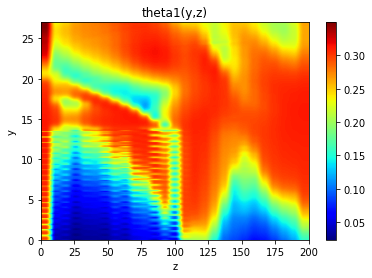

In [16]:
Z = np.flip((theta1[0:n_cells].reshape(d0, d2, d1))[d0-1, 0:d2, 0:d1], 0)
cp = plt.imshow(Z, aspect='auto', cmap = 'jet', extent = [0, Z.shape[0], 0, Z.shape[1]])
plt.colorbar(cp)
plt.title('theta1(y,z)')
plt.xlabel('z')
plt.ylabel('y')  
plt.show() 